# Convolutional Neural Network for classification on CIFAR-10 dataset





# Importing all the needed libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Loading the CIFAR-10 data
Certain augmentetion techniques are applied to our training images to improve the generalization and robustness of our model



In [2]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

batch_size = 32

transform_train = transforms.Compose([transforms.Resize((32,32)),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomRotation(10),
                                  transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                  transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                          ])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


cifar_train = datasets.CIFAR10('data', train=True, download=True, transform=transform_train)
cifar_test = datasets.CIFAR10('data', train=False, download=True, transform=transform_test)

train_size = int(0.8 * len(cifar_train))
val_size = len(cifar_train) - train_size

cifar_train, cifar_val = torch.utils.data.random_split(cifar_train, [train_size, val_size])


trainloader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

validloader = torch.utils.data.DataLoader(cifar_val, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:03<00:00, 46638936.81it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


# Visualizing the transformed images

In [3]:
def imshow(img):
  img = img / 2 + 0.5
  plt.imshow(np.transpose(img, (1, 2, 0)))

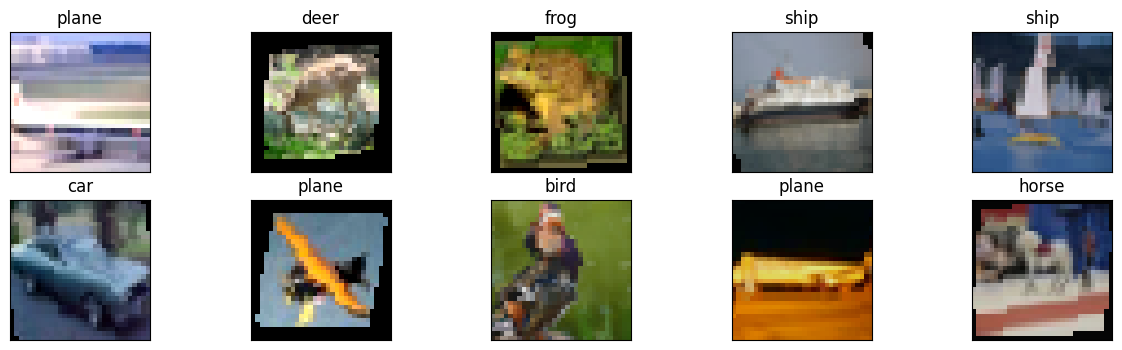

In [4]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(15, 4))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    imshow(images[i])
    ax.set_title(classes[labels[i]])

# Defining the Network architecture and parameters


In [5]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 256, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.3)
        self.bn_conv1 = nn.BatchNorm2d(32)
        self.bn_conv2 = nn.BatchNorm2d(64)
        self.bn_conv3 = nn.BatchNorm2d(128)
        self.bn_conv4 = nn.BatchNorm2d(256)
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.bn_fc2 = nn.BatchNorm1d(512)
        self.bn_fc3 = nn.BatchNorm1d(256)


    # 3 32 32
    def forward(self, x):
        x = F.relu(self.bn_conv1(self.conv1(x))) # 32 30 30
        x = self.pool(F.relu(self.bn_conv2(self.conv2(x)))) # 64 14 14
        x = self.pool(F.relu(self.bn_conv3(self.conv3(x)))) # 128 6 6
        x = self.pool(F.relu(self.bn_conv4(self.conv4(x)))) # 256 2 2
        x = x.view(-1, 256 * 2 * 2)
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = F.relu(self.bn_fc3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

def initialize_weights(model):
    for _, layer in model.named_modules():
        if isinstance(layer, (nn.Linear, nn.Conv2d)):
            init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net = CNN()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum = 0.9, weight_decay=1e-5)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25, 80], gamma=0.1)
initialize_weights(net)


# Training the Network


In [6]:
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy  = []
min_val_loss = np.inf

for epoch in range(100):
    net.train()
    running_loss = 0
    correct = 0
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = net(inputs)

        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()


    train_losses.append(running_loss / len(cifar_train))
    train_accuracy.append(correct / len(cifar_train) * 100)

    net.eval()
    running_loss = 0
    correct = 0

    with torch.no_grad():
        for data in validloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            running_loss += loss.item()


    val_losses.append(running_loss / len(cifar_val))
    val_accuracy.append(correct / len(cifar_val) * 100)
    scheduler.step()

    print(f'Epoch {epoch} train_acc: {train_accuracy[epoch]:.2f}% train_loss: {train_losses[epoch]:.4f} val_acc: {val_accuracy[epoch]:.2f}% val_loss: {val_losses[epoch]:.4f}')

    if val_losses[epoch] < min_val_loss:
        print(f'Lowest validation loss achieved. Saving model...')
        torch.save(net.state_dict(), 'model_cnn_cifar.pt')
        min_val_loss = val_losses[epoch]




Epoch 0 train_acc: 42.11% train_loss: 0.0507 val_acc: 55.21% val_loss: 0.0387
Lowest validation loss achieved. Saving model...
Epoch 1 train_acc: 55.36% train_loss: 0.0392 val_acc: 61.87% val_loss: 0.0340
Lowest validation loss achieved. Saving model...
Epoch 2 train_acc: 61.39% train_loss: 0.0344 val_acc: 63.99% val_loss: 0.0321
Lowest validation loss achieved. Saving model...
Epoch 3 train_acc: 64.62% train_loss: 0.0313 val_acc: 68.60% val_loss: 0.0280
Lowest validation loss achieved. Saving model...
Epoch 4 train_acc: 67.12% train_loss: 0.0293 val_acc: 70.44% val_loss: 0.0265
Lowest validation loss achieved. Saving model...
Epoch 5 train_acc: 69.27% train_loss: 0.0275 val_acc: 71.23% val_loss: 0.0256
Lowest validation loss achieved. Saving model...
Epoch 6 train_acc: 70.87% train_loss: 0.0262 val_acc: 74.13% val_loss: 0.0230
Lowest validation loss achieved. Saving model...
Epoch 7 train_acc: 72.02% train_loss: 0.0251 val_acc: 74.76% val_loss: 0.0228
Lowest validation loss achieved. 

# Plotting training statistics

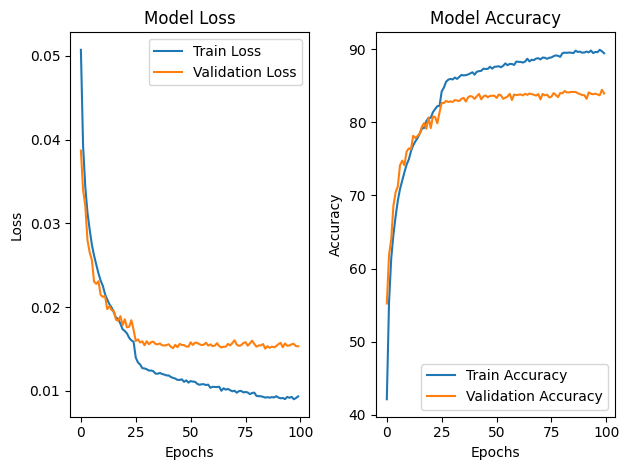

In [7]:
plt.subplot(121)
legend = ['Train Loss', 'Validation Loss']
plt.title('Model Loss')
plt.plot(train_losses, label= "Training loss")
plt.plot(val_losses, label = "Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper right')

plt.subplot(122)
legend = ['Train Accuracy', 'Validation Accuracy']
plt.title('Model Accuracy')
plt.plot(train_accuracy, label = 'Train Accuracy')
plt.plot(val_accuracy, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='lower right')

plt.tight_layout()
plt.show()

# Testing the Network

In [8]:
net.load_state_dict(torch.load('model_cnn_cifar.pt'))

net.eval()
with torch.no_grad():
    running_loss = 0
    correct = 0
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        running_loss += loss.item()

    print(f'Test Accuracy: {correct/len(cifar_test)*100:.2f}%')
    print(f'Test Loss: {running_loss/len(cifar_test)}')


Test Accuracy: 86.47%
Test Loss: 0.01345259037129581


# Visualizing Network predictions

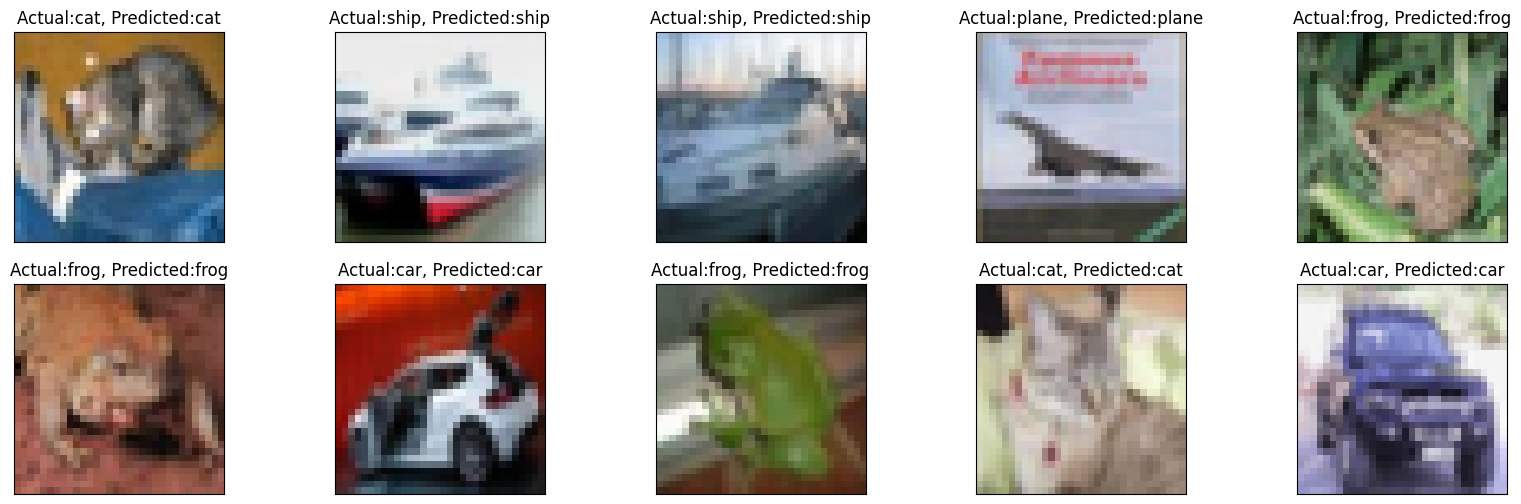

In [9]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images = images.to(device)

with torch.no_grad():
  outputs = net(images)
  _, predicted = torch.max(outputs.data, 1)

fig = plt.figure(figsize=(20, 6))
images = images.cpu().numpy()

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    imshow(images[i])
    ax.set_title(f'Actual:{classes[labels[i]]}, Predicted:{classes[predicted[i]]}')